<html>
<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: 600px; vertical-align: middle; height: 40px; margin: 10px;">
<h1 style="font-family: Georgia; color: black;">AI-Fall 01-CA3</h1>
</div>
<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: 500px; margin: 10px;">
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/225px-University_of_Tehran_logo.svg.png" width=60px width=auto style="padding:10px; vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: black;">University of Tehran </span>
</div>
<div style=" background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: 400px; height: 30px; margin: 10px;">
  <span style="font-family: Georgia; font-size:15pt; color: black; vertical-align: middle;">Saman Eslami Nazari - std id: 810199375 </span>
</div>
</html>

# Preprocessing

In [1]:
import pandas as pd

TRAIN_FILE_PATH = "./dataset/train.csv"
TEST_FILE_PATH = "./dataset/test.csv"

train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

First I will use the `Hazm` package to normalize the text. I will use different strategies and see their effects on accuracy and performance.

In [2]:
import hazm

def normalize_df(df: pd.DataFrame) -> None:
    normalizer = hazm.Normalizer()
    df['content'] = df['content'].apply(normalizer.normalize)

In [3]:
def tokenize_df(df: pd.DataFrame) -> None:
    word_tokenizer = hazm.WordTokenizer()
    df['content'] = df['content'].apply(word_tokenizer.tokenize)

# removing stop words


def rm_stop_words(df: pd.DataFrame) -> None:
    stop_words_set = set(hazm.stopwords_list())
    def stop_words_lambda(x): return [i for i in x if i not in stop_words_set]
    df['content'] = df['content'].apply(stop_words_lambda)


# removing punctuations
def rm_punctuations(df: pd.DataFrame) -> None:
    punctuations_set = set(['،', ':', '.', '؛', ')',
                           '(', '"', '»', '«', '{', '}', '[', ']', '!', '؟', '?', ';', ','])

    def remove_punctuations(x): return [
        i for i in x if i not in punctuations_set
    ]
    df['content'] = df['content'].apply(remove_punctuations)


### Stemming
Stemming is a text normalization method that removes letters from the end or the start of a word. Stemming a word doesn't necessarily result in a meaningful word; It doesn't consider the meaning of the word. Stemming is fast but less accurate than other methods like lemmatizing.

In [4]:
def stem_df(df: pd.DataFrame) -> None:
    stemmer = hazm.Stemmer()
    def stemming_lambda(x): return [stemmer.stem(i) for i in x]
    df['content'] = df['content'].apply(stemming_lambda)


### Lemmatizing
This is another method for normalizing the text. Lemmatizing is used to convert a word into its dictionary form. It considers the meaning of the word. It is usually done based on a long list of root words and takes much more time than stemming. It's more accurate though.

In [5]:
def lemmatize_df(df: pd.DataFrame) -> None:
    lemmatizer = hazm.Lemmatizer()
    def lemmatizing_lambda(x): return [lemmatizer.lemmatize(word).split('#', 1)[0] for word in x]
    df['content'] = df['content'].apply(lemmatizing_lambda)


In [6]:
def preprocess_data(df: pd.DataFrame) -> None:
    normalize_df(df)
    tokenize_df(df)
    rm_punctuations(df)
    rm_stop_words(df)
    lemmatize_df(df)
    rm_stop_words(df)

In [7]:
preprocess_data(train_df)
preprocess_data(test_df)

# The Process of the Problem

### Bayes Theorem
$$P(c|x)=\frac{P(x|c)\times P(c)}{P(x)}$$
$$P(c|x)=P(x_1|c)\times P(x_2|c)\times ...\times P(x_n|c)\times P(c)$$

- Posterior Probability $P(c|x)$:<br>
This is the probability of $c$ in case of seeing $x$. Here it is equal to the probability the news having the label $c$ in case of seeing the word $x$ in it.

- Likelihood $P(x|c)$:<br>
Probability of $x$ in case of $c$. In this project, it is equal to the probability of seeing word $x$ while reading a news with the label $c$.

- Prior $P(c)$:<br>
Probability of having the class $c$. Here, this is equal to the number of news in class $c$ divided by the total count of news.

- Evidence $P(x)$:<br>
The probability of seeing word $x$ in a news. This is equal to the total count of $x$ occurrences in every news (without regarding their labels) divided by the total count of the words in the whole dataset.

### Bigrams
- What will happen if she leaves him.
- In autumn, Leaves fall.

In the first example, our bigram would be "leaves him" which is used as a verb and is beside the word "him"; With this bigram we can deduct that this "leaves" is not the plural form of the "leaf". In the second example though, the bigram will be "Leaves fall". This can help us to determine which "leaves" is used here.<br>
In this example we won't need a longer n-gram, and bigram is enough.

To implement the bayesian classifier, I will first group the labels column and gather each label's words into a single row. Then I will count each label's words and map it to the corresponding label.

In [8]:
def map_words_cnt(df: pd.DataFrame, labels: list[str]) -> dict[str, pd.Series]:
    train_words_cnt_label_map: dict[str, pd.Series] = {}

    for label in labels:
        current_label_words = \
            df.loc[df['label'] == label]['content'].apply(pd.Series).\
            stack().reset_index(drop=True)

        train_words_cnt_label_map[label] = current_label_words.value_counts()
    return train_words_cnt_label_map


After counting words of each label and creating the map we wanted, I will need to calculate the probability of each feature. $P(word|label)$ is what we're looking for. As the value of $P$ might become too low, I will save its logarithm value to prevent the miscalculations due to floating point error.

In [9]:
import math

def calc_prob(words_cnt: pd.Series) -> pd.Series:
    result = pd.Series(index=words_cnt.index)
    total_words_cnt = words_cnt.sum()
    for word, count in words_cnt.items():
        result[word] = math.log2(count / total_words_cnt)
    return result


Now, its time to predict labels. For this purpose I will write the `predict_label` function that will get a text and the `words probability : label` map as inputs and return the predicted label. It will iterate over each word on the text and product the $P(word|label)$ s. Then it will choose the product with maximum value.

## Additive Smoothing

Sometime we might encounter a feature that was not seen before. In that case, the probability of that feature in case of a label becomes zero; Therefore the Naive Bayes solution will say that the text with this specific feature does not belong to a label; This decision is too pessimistic and can be wrong very often.
A solution to this problem is "Additive Smoothing". To avoid zero probability of unseen features, we will add a noise ($\alpha$) to $P(feature|class)$:
$$P(w|c)=\frac{total\: count\: of\: ws\: in\: c+\alpha}{total\: words\: in\: c + \alpha \times number\: of\: unique\: words\: in\: c}$$
To apply additive smoothing, I will rewrite the `calc_prob` based on the aforementioned formula:

In [10]:
def calc_prob_additive_smoothing(alpha: float, words_cnt: pd.Series) -> pd.Series:
    result = pd.Series(index=words_cnt.index)
    total_words_cnt = words_cnt.sum()
    unique_words_count = len(words_cnt.index)
    for word, count in words_cnt.items():
        result[word] = math.log2((count + alpha) / (total_words_cnt + alpha * unique_words_count))
    return result

In [11]:
from typing import Callable


def map_words_prob(calc_prob: Callable[[pd.Series], None], words_cnt_map: dict[str, pd.Series]) -> dict[str, pd.Series]:
    result: dict[str, pd.Series] = {x: None for x in words_cnt_map.keys()}
    for word, count in words_cnt_map.items():
        result[word] = calc_prob(count)
    return result


def labels_prob(words_cnt_map: dict[str, pd.Series], labels: list[str]) -> dict[str, float]:
    result: dict[str, float] = {}
    total_labels_count: int = 0
    for label, words_cnt in words_cnt_map.items():
        total_labels_count += words_cnt.sum()
    for label in labels:
        result[label] = words_cnt_map[label].sum() / total_labels_count
    return result


For simplicity and a cleaner code, I will create the `ProbMap` class that will abstract the above functions and provide a uniform interface to access probabilities, whether additive smoothing is activated or not.

In [12]:
from typing import Optional
from functools import partial


class ProbMap:
    def __init__(
            self,
            df: pd.DataFrame,
            labels: list[str],
            additive_smoothing: Optional[bool] = False,
            alpha: Optional[float] = 1):

        self._additive_smoothing = additive_smoothing
        self._alpha = alpha
        self._labels = labels
        self._words_cnt_map = map_words_cnt(df, self._labels)
        self._labels_prob = labels_prob(self._words_cnt_map, self._labels)
        prob_calculator = None
        if additive_smoothing:
            prob_calculator = partial(calc_prob_additive_smoothing, alpha)
        else:
            prob_calculator = calc_prob

        self._words_prob_map = map_words_prob(
            prob_calculator, self._words_cnt_map
        )

    def get_word_prob(self, word: str, label: str) -> float:
        if word in self._words_prob_map[label]:
            return self._words_prob_map[label][word]
        if self._additive_smoothing:
            return math.log(
                self._alpha /
                (self._words_cnt_map[label].sum() +
                 len(self._words_cnt_map[label].index.unique()) * self._alpha)
            )
        return -math.inf

    def get_labels_prob(self, label) -> float:
        return self._labels_prob[label]


In the end I shall write a function that will get the test dataset and predict its labels.

In [13]:
def predict_label(
    text: list[str],
    prob_map: ProbMap,
    labels: list[str]) -> str | None:

    result_map: dict[str, float] = {x : 0 for x in labels}

    for label in labels:
        cur_prob = 0
        for word in text:
            cur_prob += prob_map.get_word_prob(word, label)
        result_map[label] = cur_prob + prob_map.get_labels_prob(label)

    if max(result_map.values()) == -math.inf:
        return None
    return max(result_map, key=result_map.get)


In [14]:
from copy import deepcopy

def predict_dataset(df: pd.DataFrame, words_prob_map: ProbMap, labels: list[str]) -> pd.DataFrame:
    result_df = deepcopy(df)
    predict_list: list[str] = []
    for index, row in df.iterrows():
        predict_list.append(predict_label(row['content'], words_prob_map, labels))
    result_df.insert(len(result_df.columns), 'predicted_label', predict_list)
    return result_df


# Correctness 

In [15]:
labels = train_df['label'].unique()

words_cnt_map = map_words_cnt(train_df, labels)

for label, words_count in words_cnt_map.items():
    words_cnt_map[label] = words_count.nlargest(5)


C:\Users\Emertat\AppData\Local\Temp\ipykernel_16632\2781065564.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[df['label'] == label]['content'].apply(pd.Series).\


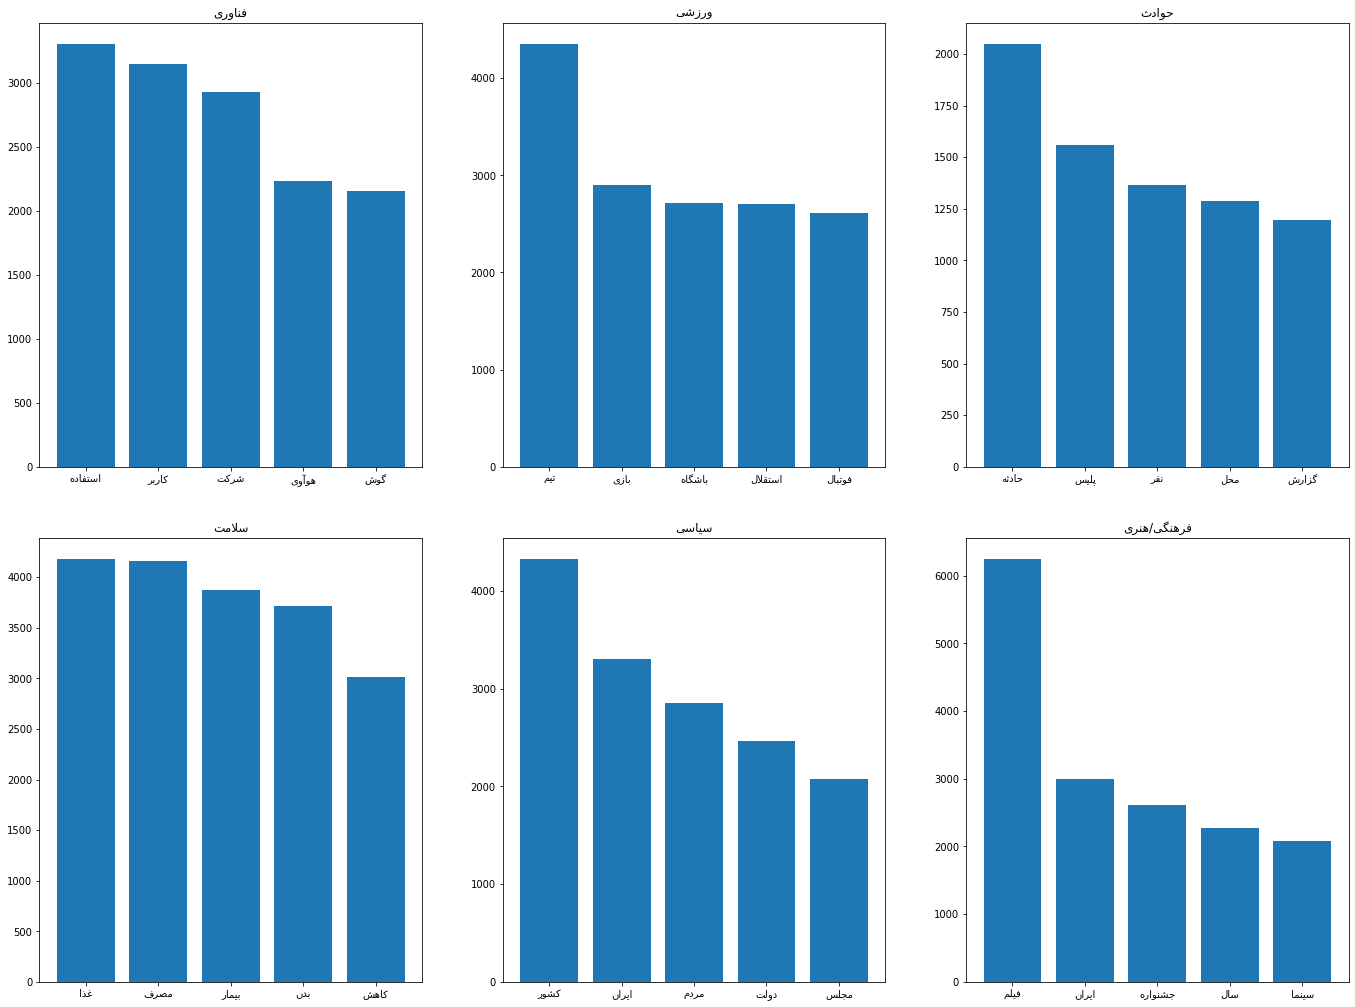

In [16]:
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display

fig, axes = plt.subplots(
    nrows=2, ncols=math.ceil(len(words_cnt_map)/2), figsize=(20, 15)
)
fig.tight_layout(pad=5.0)

ax_index = 0
for label, count in words_cnt_map.items():
    axes.flatten()[ax_index].bar(
        [get_display(reshape(word)) for word in count.index],
        [x[1] for x in count.items()]
    )
    axes.flatten()[ax_index].title.set_text(get_display(reshape(label)))
    ax_index += 1


# Evaluation

## Accuracy
To calculate the accuracy of a predicted dataset, I will simply count the number of labels that are predicted correctly (that is rows with $predicted\: label = actual\: label$) and divide it by the total count of rows:
$$Accuracy = \frac{Correctly\: predicted}{Total}$$

In [17]:
def accuracy(y: pd.Series, y_pred: pd.Series) -> float:
    df = pd.DataFrame({'y': y, 'y_pred': y_pred})
    return df[df['y'] == df['y_pred']].shape[0] / df.shape[0]


## Precision
Precision is calculated for each class. It is equal to the number of the correctly predicted values in a single class, divided by the total number of the rows that were predicted to belong to that class (whether it's wrong or right):
$$Precision[c] = \frac{Correctly\: predicted\: to\: be\: in\: class\: c}{Total\: predictions\: of\: class\: c}$$

In [18]:
def precision(y: pd.Series, y_pred: pd.Series) -> dict[str, float]:
    df = pd.DataFrame({'y': y, 'y_pred': y_pred})
    labels = list(y.unique())
    result: dict[str, float] = {x: 0 for x in labels}
    for label in labels:
        result[label] = \
            df[(df['y'] == df['y_pred']) & (df['y'] == label)].shape[0] / \
            df[df['y_pred'] == label].shape[0]
    return result


## Recall
Recall is very similar to Precision; Their only difference is that instead of dividing the fraction by the $Total predictions of class c$, we will divide it by the rows that actually belong to the class c:
$$Recall[c] = \frac{Correctly\: predicted\: to\: be\: in\: c}{Total\: class}$$

In [19]:
def recall(y: pd.Series, y_pred: pd.Series) -> dict[str, float]:
    df = pd.DataFrame({'y': y, 'y_pred': y_pred})
    labels = list(y.unique())
    result: dict[str, float] = {x: 0 for x in labels}
    for label in labels:
        result[label] = \
            df[(df['y'] == df['y_pred']) & (df['y'] == label)].shape[0] / \
            df[df['y'] == label].shape[0]
    return result

### Precision vs Recall
Precision indicates how many of our predictions where correct. For example if we calculate the precision of our model in class c, it'll tell us how many of the rows that were predicted to be in c were actually in c.<br>
Recall on the other hand will tell us how many of the rows that were actually in class c, were predicted to be in c.<br>
Precision or recall should not be used without the other one. Consider a model that among 100 news with label c, predicts 10 of them to have the label c but doesn't predict the other 90 correctly. In this case, the model has a precision of 100% but isn't preforming very good with recall method. Take another model that predicts every news to have the label c. Ofcourse this model has a recall of 100% percent, but it doesn't have a good precision.

## F1
F1 uses a harmonic average of recall and precision. Its different with normal averaging is that it gives more weight to the lower values. For example if we have a precision of 100% and a recall of 0%, The F1 will be 0.
$$F1 = 2\times \frac{Precision \times Recall}{Precision + Recall}$$

In [20]:
def f1(y: pd.Series, y_pred: pd.Series) -> dict[str, float]:
    precision_dict = precision(y, y_pred)
    recall_dict = recall(y, y_pred)

    labels = list(y.unique())
    result: dict[str, float] = {x: 0 for x in labels}
    for label in labels:
        result[label] = \
            2 * (precision_dict[label] * recall_dict[label]) / \
            (precision_dict[label] + recall_dict[label])

    return result


### Macro Avg
This is the average of a metric for each class in the model. Here we will only calculate Macro F1:

In [21]:
def macro_f1(y: pd.Series, y_pred: pd.Series) -> float:
    f1_dict = f1(y, y_pred)
    result: float = 0
    for label, f1_value in f1_dict.items():
        result += f1_value
    result /= len(f1_dict)
    return result

### Weighted Avg
It is the weighted average of a metric with weights equal to the count of samples in each class. Again, I will only calculate the weighted average of f1:

In [22]:
def weighted_f1(y: pd.Series, y_pred: pd.Series) -> float:
    f1_dict = f1(y, y_pred)
    weights: dict[str, int] = {
        l: y.value_counts()[l] for l in y.unique()
    }

    result: float = 0
    weights_sum = 0
    for label, f1_value in f1_dict.items():
        result += f1_value * weights[label]
        weights_sum += weights[label]
    result /= weights_sum
    return result

### Micro Avg
This is the average of metrics if all classes were the same. Micro recall, Micro precision, Micro F1 and accuracy are all the same:

In [23]:
def micro_f1(y: pd.Series, y_pred: pd.Series) -> float:
    return accuracy(y, y_pred)


Now lets use all of the aforementioned methods to access out model.

In [24]:
def print_precision(predicted_dataset: pd.DataFrame, labels: list[str]) -> None:
    print("- Precision:")
    precision_dict = precision(
        predicted_dataset['label'], predicted_dataset['predicted_label']
    )
    for label in labels:
        print(f"\t- {label}: {precision_dict[label]}")


def print_recall(predicted_dataset: pd.DataFrame, labels: list[str]) -> None:
    print("- Recall:")
    recall_dict = recall(
        predicted_dataset['label'], predicted_dataset['predicted_label']
    )
    for label in labels:
        print(f"\t- {label}: {recall_dict[label]}")


def print_f1(predicted_dataset: pd.DataFrame, labels: list[str]) -> None:
    print("- F1:")
    f1_dict = f1(
        predicted_dataset['label'], predicted_dataset['predicted_label']
    )
    for label in labels:
        print(f"\t- {label}: {f1_dict[label]}")


### Without Additive Smoothing

In [25]:
labels = list(train_df['label'].unique())

non_smoothed_prob_map = ProbMap(train_df, labels, False)
non_smoothed_predicts = predict_dataset(test_df, non_smoothed_prob_map, labels)

print(
    f"- Accuracy: {accuracy(non_smoothed_predicts['label'], non_smoothed_predicts['predicted_label'])}"
)

print_precision(non_smoothed_predicts, labels)
print_recall(non_smoothed_predicts, labels)
print_f1(non_smoothed_predicts, labels)

print(
    f"- Macro F1: {macro_f1(non_smoothed_predicts['label'], non_smoothed_predicts['predicted_label'])}"
)
print(
    f"- Weighted F1: {weighted_f1(non_smoothed_predicts['label'], non_smoothed_predicts['predicted_label'])}"
)
print(
    f"- Micro F1: {micro_f1(non_smoothed_predicts['label'], non_smoothed_predicts['predicted_label'])}"
)


C:\Users\Emertat\AppData\Local\Temp\ipykernel_16632\2781065564.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[df['label'] == label]['content'].apply(pd.Series).\
C:\Users\Emertat\AppData\Local\Temp\ipykernel_16632\3824479153.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = pd.Series(index=words_cnt.index)


- Accuracy: 0.17668161434977578
- Precision:
	- فناوری: 0.7083333333333334
	- ورزشی: 0.9555555555555556
	- حوادث: 0.8484848484848485
	- سلامت: 0.96
	- سیاسی: 0.8363636363636363
	- فرهنگی/هنری: 0.8478260869565217
- Recall:
	- فناوری: 0.10119047619047619
	- ورزشی: 0.22631578947368422
	- حوادث: 0.14
	- سلامت: 0.13559322033898305
	- سیاسی: 0.23
	- فرهنگی/هنری: 0.21666666666666667
- F1:
	- فناوری: 0.17708333333333334
	- ورزشی: 0.36595744680851067
	- حوادث: 0.240343347639485
	- سلامت: 0.2376237623762376
	- سیاسی: 0.36078431372549014
	- فرهنگی/هنری: 0.3451327433628319
- Macro F1: 0.2878208245409814
- Weighted F1: 0.29030560261212185
- Micro F1: 0.17668161434977578


### With Additive Smoothing

In [26]:
smoothed_prob_map = ProbMap(train_df, labels, True, 1)
smoothed_predicts = predict_dataset(test_df, smoothed_prob_map, labels)

print(
    f"- Accuracy: {accuracy(smoothed_predicts['label'], smoothed_predicts['predicted_label'])}"
)

print_precision(smoothed_predicts, labels)
print_recall(smoothed_predicts, labels)
print_f1(smoothed_predicts, labels)

print(
    f"- Macro F1: {macro_f1(smoothed_predicts['label'], smoothed_predicts['predicted_label'])}"
)
print(
    f"- Weighted F1: {weighted_f1(smoothed_predicts['label'], smoothed_predicts['predicted_label'])}"
)
print(
    f"- Micro F1: {micro_f1(smoothed_predicts['label'], smoothed_predicts['predicted_label'])}"
)

C:\Users\Emertat\AppData\Local\Temp\ipykernel_16632\2781065564.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[df['label'] == label]['content'].apply(pd.Series).\
C:\Users\Emertat\AppData\Local\Temp\ipykernel_16632\3798648905.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = pd.Series(index=words_cnt.index)


- Accuracy: 0.9210762331838565
- Precision:
	- فناوری: 0.9612903225806452
	- ورزشی: 0.9526315789473684
	- حوادث: 0.8326180257510729
	- سلامت: 0.9710982658959537
	- سیاسی: 0.8815165876777251
	- فرهنگی/هنری: 0.9738562091503268
- Recall:
	- فناوری: 0.8869047619047619
	- ورزشی: 0.9526315789473684
	- حوادث: 0.97
	- سلامت: 0.9491525423728814
	- سیاسی: 0.93
	- فرهنگی/هنری: 0.8277777777777777
- F1:
	- فناوری: 0.9226006191950464
	- ورزشی: 0.9526315789473683
	- حوادث: 0.8960739030023094
	- سلامت: 0.96
	- سیاسی: 0.9051094890510948
	- فرهنگی/هنری: 0.8948948948948948
- Macro F1: 0.9218850808484523
- Weighted F1: 0.921286693736798
- Micro F1: 0.9210762331838565


### Analyzing Differences
The model doesn't behave well without additive smoothing. This is because of the problem mentioned in the "Additive Smoothing" section. There are words on the test dataset that didn't exist in training dataset, Therefore the classifier will not predict it to have any label. But it does have good results in precision; This is because if we have a text that we have observed its words in the training set before, we will be able to predict its label with more confidence. On the other hand, the classifier with additive smoothing can perform better in general. the reason behind this was mentioned in the "Additive Smoothing" section.

In [27]:
display(non_smoothed_predicts[non_smoothed_predicts['label'] != non_smoothed_predicts['predicted_label']].head(5))
display(smoothed_predicts[smoothed_predicts['label'] != smoothed_predicts['predicted_label']].head(5))

,label,content,predicted_label
0,فناوری,"[اعلام, لیس, ۲۳, شرکت, مجاز, ثبت, سفارش, ارائه...",None
1,فرهنگی/هنری,"[استاد, علم, قرائت, قرآن, کریم, ریشه, موسیقی, ...",None
2,حوادث,"[آتش, سوزی‌های, زنجیره, جنگل, زاگرس, استان, ای...",None
3,فناوری,"[استفاده, سرویس‌های, iMassage, Facetime, محصول...",None
4,حوادث,"[دادستان, عموم, انقلاب, یاسوج, ۱۰, میلیون, دلا...",None


,label,content,predicted_label
30,فرهنگی/هنری,"[-, چهارشنبه, تیر, ۱۴۰۱, اتفاق, نادر, جالب, رخ...",سیاسی
42,فرهنگی/هنری,"[یورگن, هابرماس, فیلسوف, جامعه, شناس, نامدار, ...",ورزشی
45,فرهنگی/هنری,"[اعتراض, گسترده, کاربر, اظهارات, وزیر, امورخار...",سیاسی
61,فرهنگی/هنری,"[فهرست, نامزد, جوایز, گلدن, گلوب, ۲۰۱۷, درحالی...",ورزشی
65,حوادث,"[ملی‌پوش, سابق, دوچرخه, سوار, ایران, تصادف, فا...",فناوری


Most of the mis-predicted words are in the Art/Culture class. This is because some classes have high occurrence of words that are common among other classes. We can solve this problem by removing these words in preprocessing phase.